Site to Database: https://www.ncbi.nlm.nih.gov/geo/

# **Microarray Data**

Specify directory for where to store Differential Gene Expression Data

In [6]:
microarray_diff_exp_data <- "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Microarray Differential Gene Expression/ATB_v_OD/"

Load packages

In [7]:
library(Biobase)
library(GEOquery)
library(limma)
library(repr)

## *Function* to subset rows of normalized gene expression matrix

- The function maps each gene symbol to the probe with the highest gene expression sum across all samples in the matrix. 
- It then filters the matrix accordingly and drops rows/probes that either 
    1. did not map to any gene symbol
    1. mapped to some gene symbol **x** but had lower expression sum across samples than another probe that mapped to gene symbol **x**

In [8]:
#define operator
`%notin%` <- Negate(`%in%`)

reduce_expression_matrix_rows <- function(gset, microarray_platform) {
    
    #filter rows of exp matrix, keep only one probe per gene (symbol) with the highest expression sum across samples
    
    #useful commands for de-bugging
    # gset
    # varLabels(featureData(gset))

    #store expression matrix & get the sum for each row/probe from expression matrix
    exp_matrix <- exprs(gset)
    probe_sums <- rowSums(exp_matrix)
    probe_IDs <- names(probe_sums)

    #iterate through all rows/probes and store non-redundant gene symbols (first check to see that string is not empty) store in vector

    #initialize list that will hold information for each row/probe: probe ID (index), list[vector(gene symbols), float(row/probe exp sum)]
    probe_info <- list()

    if ((microarray_platform == 'GPL6947') | (microarray_platform == 'GPL4133') | (microarray_platform == 'GPL10558') | (microarray_platform == 'GPL570') | (microarray_platform == 'GPL11532') | (microarray_platform == 'GPL6102') | (microarray_platform == 'GPL6480') | (microarray_platform == 'GPL6883')) {

        gene_symbol_labels <- fData(gset)$Gene.symbol #get the gene symbols mapped to each row/probe

        i <- 1 #indexes rows/probes
        for (gene_symbol_i in gene_symbol_labels) {

            #get info for row
            probe_i_ID = probe_IDs[i]
            probe_i_sum = probe_sums[i]
            probe_i_gene_symbols = vector()

            #multiple genes
            if ((gene_symbol_i != '') & grepl('///', gene_symbol_i, fixed = TRUE)) {

                for (gene_symbol_j in unlist(strsplit(gene_symbol_i, '///', fixed = TRUE))) {
                    probe_i_gene_symbols <- c(probe_i_gene_symbols, trimws(gene_symbol_j))
                }
            #one gene
            } else if (gene_symbol_i != '') {

                probe_i_gene_symbols <- c(probe_i_gene_symbols, trimws(gene_symbol_i))
            }
            probe_info[[probe_i_ID]] <- list(probe_i_gene_symbols, probe_i_sum)
            i = i + 1
        }
    } else if (microarray_platform == 'GPL5175') {

        gene_symbol_labels <- fData(gset)$gene_assignment #get the gene symbols mapped to each row/probe

        i <- 1 #indexes rows/probes
        for (gene_assignment_i in gene_symbol_labels) {

            #get info for row
            probe_i_ID = probe_IDs[i]
            probe_i_sum = probe_sums[i]
            probe_i_gene_symbols = vector()

            #multiple genes
            if ((gene_assignment_i != '') & grepl('///', gene_assignment_i, fixed = TRUE)) {

                for (gene_assignment_j in unlist(strsplit(gene_assignment_i , '///' , fixed = TRUE))) {
                    gene_symbol_i <- unlist(strsplit(gene_assignment_j, '//'))[2]
                    probe_i_gene_symbols <- c(probe_i_gene_symbols, trimws(gene_symbol_i))
                }
            #one gene
            } else if ((gene_assignment_i != '') & grepl('//', gene_assignment_i, fixed = TRUE)) {

                gene_symbol_i <- unlist(strsplit(gene_assignment_i, '//'))[2]
                probe_i_gene_symbols <- c(probe_i_gene_symbols, trimws(gene_symbol_i))
            }   
            probe_info[[probe_i_ID]] <- list(probe_i_gene_symbols, probe_i_sum)
            i = i + 1
        }
    } else if (microarray_platform == 'GPL16951') {

        gene_symbol_labels <- fData(gset)$Gene_symbol #get the gene symbols mapped to each row/probe

        i <- 1 #indexes rows/probes
        for (gene_symbol_i in gene_symbol_labels) {

            #get info for row
            probe_i_ID = probe_IDs[i]
            probe_i_sum = probe_sums[i]
            probe_i_gene_symbols = vector()

            #multiple genes
            if ((gene_symbol_i != 'previous version conserved probe') & (gene_symbol_i != '') & grepl('|', gene_symbol_i, fixed = TRUE)) {

                for (gene_symbol_j in unlist(strsplit(gene_symbol_i, '|', fixed = TRUE))) {
                    probe_i_gene_symbols <- c(probe_i_gene_symbols, trimws(gene_symbol_j))
                }
            #one gene
            } else if ((gene_symbol_i != 'previous version conserved probe') & (gene_symbol_i != '')) {

                probe_i_gene_symbols <- c(probe_i_gene_symbols, trimws(gene_symbol_i))
            }   
            probe_info[[probe_i_ID]] <- list(probe_i_gene_symbols, probe_i_sum)
            i = i + 1
        }
    }

    #iterate through each probe - gene symbol list - gene exp sum, keep track of the probe with the largest sum (across samples) for each gene symbol
    #> each gene symbol will get mapped to only the row/probe with the highest expression sum across samples
    probe_exp_sum_by_gene = list()
    for (probe_i in names(probe_info)) {

        gene_symbol_vec_probe_i = probe_info[probe_i][[1]][[1]] #holds the vector of gene symbols
        gene_symbol_exp_sum = unname(probe_info[probe_i][[1]][[2]]) #holds the probe exp sum (total across samples)

        #iterate through gene symbols that correspond to this probe (if there are any)
        if (length(gene_symbol_vec_probe_i) > 0) { #there's at least 1 gene symbol
            for (gene_symbol_i in gene_symbol_vec_probe_i) { #iterate through gene symbols

                #if gene symbol not present in list, then store gene symbol along with (probe exp sum) & (probe ID)
                if (gene_symbol_i %notin% names(probe_exp_sum_by_gene)) {
                    probe_exp_sum_by_gene[[gene_symbol_i]] <- list(probe_i, gene_symbol_exp_sum)

                #if gene symbol is present in list, then replace gene symbol along with (probe exp sum) & (probe ID) IF (probe exp sum) > than the (probe exp sum) currently in list
                } else if ((gene_symbol_i %in% names(probe_exp_sum_by_gene)) & (gene_symbol_exp_sum > probe_exp_sum_by_gene[[gene_symbol_i]][[2]])) {
                    probe_exp_sum_by_gene[[gene_symbol_i]] <- list(probe_i, gene_symbol_exp_sum)
                }
            }
        }
    }

    #create a vector of probe IDs we want to keep
    probe_IDs_to_keep <- vector()
    for (gene_symbol_i in names(probe_exp_sum_by_gene)) {
        probe_IDs_to_keep <- c(probe_IDs_to_keep, probe_exp_sum_by_gene[[gene_symbol_i]][[1]])
    }
    #some probe IDs may be duplicated since some probes map to multiple genes
    probe_IDs_to_keep <- unique(probe_IDs_to_keep)

    #create a boolean vector to filter Gene Expression matrix (TRUE = keep row/probe , FALSE = drop probe)
    exp_probe_bool_filter = vector()
    for (probe_id in row.names(exp_matrix)) {
        if (probe_id %in% probe_IDs_to_keep) {
            exp_probe_bool_filter <- c(exp_probe_bool_filter, TRUE)
        } else {
            exp_probe_bool_filter <- c(exp_probe_bool_filter, FALSE)
        }
    }

    #subset to rows that have the highest expression sums for each gene
    sel <- which(exp_probe_bool_filter == TRUE)
    gset <- gset[sel, ]
    return(gset)
}

## *Function* to draw boxplot

In [9]:
draw_boxplot_for_samples <- function(GSE_ID, microarray_platform, gsms, labels) {
        
    # Boxplot for selected GEO samples

    # load series and platform data from GEO
    gset <- getGEO(GSE_ID, GSEMatrix =TRUE, getGPL=FALSE)
    if (length(gset) > 1) idx <- grep(microarray_platform, attr(gset, "names")) else idx <- 1
    gset <- gset[[idx]]

    # group names for all samples in a series
    sml <- c()
    for (i in 1:nchar(gsms)) { sml[i] <- substr(gsms,i,i) }
    sml <- paste("G", sml, sep="")  # set group names

    # eliminate samples marked as "X"
    sel <- which(sml != "X")
    sml <- sml[sel]
    gset <- gset[ ,sel]

    # order samples by group
    ex <- exprs(gset)[ , order(sml)]
    sml <- sml[order(sml)]
    fl <- as.factor(sml)

    # set parameters and draw the plot
    palette(c("#dfeaf4","#dff4e4", "#AABBCC"))
    options(repr.plot.width=4+dim(gset)[[2]]/5, repr.plot.height=6)
    par(mar=c(2+round(max(nchar(sampleNames(gset)))/2),4,2,1))
    title <- paste (GSE_ID, '/', annotation(gset), " selected samples", sep ='')
    boxplot(ex, boxwex=0.6, notch=T, main=title, outline=FALSE, las=2, col=fl)
    legend("topleft", labels, fill=palette(), bty="n")
}

## *Function* for differential gene expression analysis

In [10]:
diff_exp_analysis_for_samples <- function(GSE_ID, microarray_platform, gsms, microarray_diff_exp_data) {
    
    # Differential expression analysis with limma

    # load series and platform data from GEO
    gset <- getGEO(GSE_ID, GSEMatrix =TRUE, AnnotGPL=TRUE)
    if (length(gset) > 1) idx <- grep(microarray_platform, attr(gset, "names")) else idx <- 1
    gset <- gset[[idx]]

    # make proper column names to match toptable 
    fvarLabels(gset) <- make.names(fvarLabels(gset))

    # Reduce rows to one probe per gene (keep probes with the highest expression sum across samples)
    gset <- reduce_expression_matrix_rows(gset, microarray_platform)

    # group names for all samples
    sml <- c()
    for (i in 1:nchar(gsms)) { sml[i] <- substr(gsms,i,i) }

    # eliminate samples marked as "X"
    sel <- which(sml != "X")
    sml <- sml[sel]
    gset <- gset[ ,sel]

    # log2 transform
    ex <- exprs(gset)
    qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
    LogC <- (qx[5] > 100) ||
              (qx[6]-qx[1] > 50 && qx[2] > 0) ||
              (qx[2] > 0 && qx[2] < 1 && qx[4] > 1 && qx[4] < 2)
    if (LogC) { ex[which(ex <= 0)] <- NaN
      exprs(gset) <- log2(ex) }

    # set up the data and proceed with analysis
    sml <- paste("G", sml, sep="")    # set group names
    fl <- as.factor(sml)
    gset$description <- fl
    design <- model.matrix(~ description + 0, gset)
    colnames(design) <- levels(fl)
    fit <- lmFit(gset, design)
    cont.matrix <- makeContrasts(G1-G0, levels=design)
    fit2 <- contrasts.fit(fit, cont.matrix)
    fit2 <- eBayes(fit2, 0.01)
    tT <- topTable(fit2, adjust="fdr", sort="none" , n=Inf)

    write.csv(tT, paste0(microarray_diff_exp_data , GSE_ID, '.csv'))
}

## Dataset 1

### GSE34608 Germany, TB and sarcoidosis (microarray, GPL6480)

- Subjects:44
- Disease status: sarcoidosis (n=18), tuberculosis (n=8), control (n=18)
- Disease status definition: sarcoidosis, tuberculosis, control.

Compare ATB (**n=8**) to OD (**n=18**)

#### Check distribution of expression values across samples

Found 2 file(s)
GSE34608-GPL6480_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
GSE34608-GPL7731_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


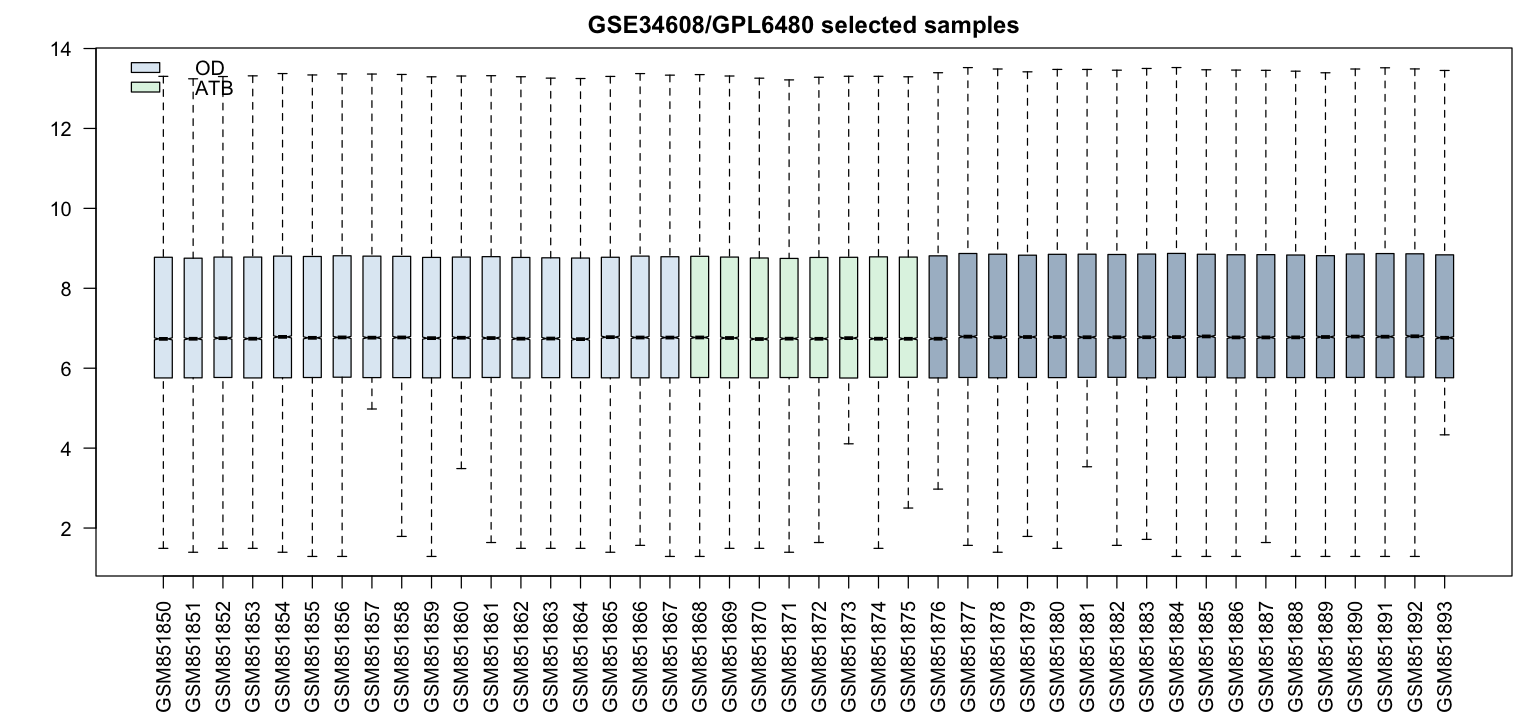

In [11]:
gsms <- "00000000000000000011111111XXXXXXXXXXXXXXXXXX"
labels <- c("OD","ATB")
draw_boxplot_for_samples("GSE34608", "GPL6480", gsms, labels)

#### Run differential expression analysis between sample groups and export results as CSV file

In [12]:
gsms <- "00000000000000000011111111XXXXXXXXXXXXXXXXXX"
diff_exp_analysis_for_samples("GSE34608", "GPL6480", gsms, microarray_diff_exp_data)

Found 2 file(s)
GSE34608-GPL6480_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GSE34608-GPL6480_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
File stored at: 
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GPL6480.annot.gz
GSE34608-GPL7731_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GSE34608-GPL7731_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.
Warning message in download.file(myurl, destfile, mode = mode, quiet = TRUE, method = getOption("download.file.method.GEOquery")):
“cannot open URL 'https://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL7nnn/GPL7731/annot/GPL7731.annot.gz': HTTP status was '404 Not Found'”Annotation GPL not available, so w

## Dataset 2

### GSE37250 Cape Town, South Africa (n=300) and Karonga, Malawi (n=237) (microarray, GPL10558)

- Subjects:537
- Disease status: active tuberculosis (n=195), latent TB infection (n=167), other disease (n=175)
- Disease stage (the second layer): HIV positive (n=274) and negative (n=263)
- Disease status definition: active TB (TB) compared to latent TB infection (LTBI) as well as to other diseases (OD)

Compare ATB (**n=195**) to OD (**n=175**)

#### Check distribution of expression values across samples

Found 1 file(s)
GSE37250_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


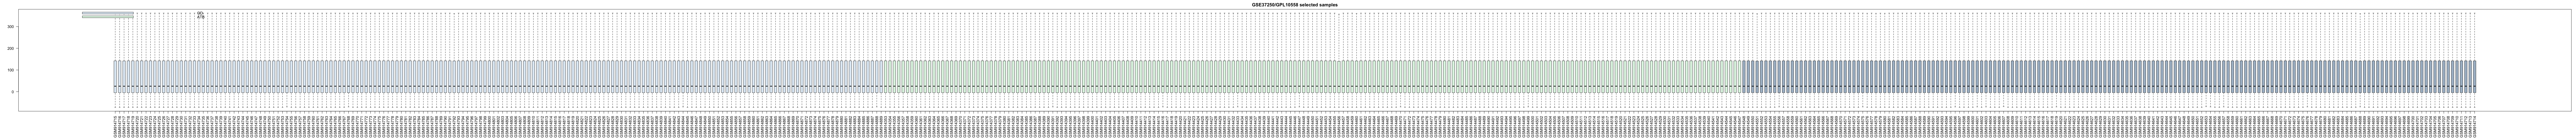

In [13]:
gsms <- paste0("11111111111111111111111111111111111111111111111111",
        "11111111111111111111111111111111111111111111111111",
        "11111111111111111111111111111111111111111111111111",
        "111111111111111111111111111111111111111111111XXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXX00000000000000000000000000000000000000",
        "00000000000000000000000000000000000000000000000000",
        "00000000000000000000000000000000000000000000000000",
        "0000000000000000000000000000000000000")
labels <- c("OD","ATB")
draw_boxplot_for_samples("GSE37250", "GPL10558", gsms, labels)

#### Run differential expression analysis between sample groups and export results as CSV file

In [14]:
gsms <- paste0("11111111111111111111111111111111111111111111111111",
        "11111111111111111111111111111111111111111111111111",
        "11111111111111111111111111111111111111111111111111",
        "111111111111111111111111111111111111111111111XXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXX00000000000000000000000000000000000000",
        "00000000000000000000000000000000000000000000000000",
        "00000000000000000000000000000000000000000000000000",
        "0000000000000000000000000000000000000")
diff_exp_analysis_for_samples("GSE37250", "GPL10558", gsms, microarray_diff_exp_data)

Found 1 file(s)
GSE37250_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GSE37250_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
File stored at: 
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GPL10558.annot.gz
Warning message:
“13 parsing failures.
  row     col               expected          actual         file
29686 Gene ID no trailing characters ///283507       literal data
29841 Gene ID no trailing characters ///2074         literal data
30401 Gene ID no trailing characters ///27185///7257 literal data
31184 Gene ID no trailing characters ///57592        literal data
31271 Gene ID no trailing characters ///3199         literal data
..... ....... ...................... ............... ............
See problems(...) for more details.
”Warning message:
“Partial NA coefficients for 378 probe(s

## Dataset 3

### GSE39939 A paediatric cohort from Kenya with HIV+/- (microarray, GPL10558)

- Subjects:157
- Disease status: active tuberculosis (culture confirmed) (n=35), other disease (n=55), latent TB infection (n=14), active tuberculosis (culture negative) (n=44), other disease (IGRA +)(n=9)
- Disease stage (the second layer): HIV positive (n=274) and negative (n=263)
- Disease status definition: active TB (culture confirmed), active TB (culture negative), LTBI or other disease

Compare ATB (**n=35**) to OD (**n=55**)

#### Check distribution of expression values across samples

Found 1 file(s)
GSE39939_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


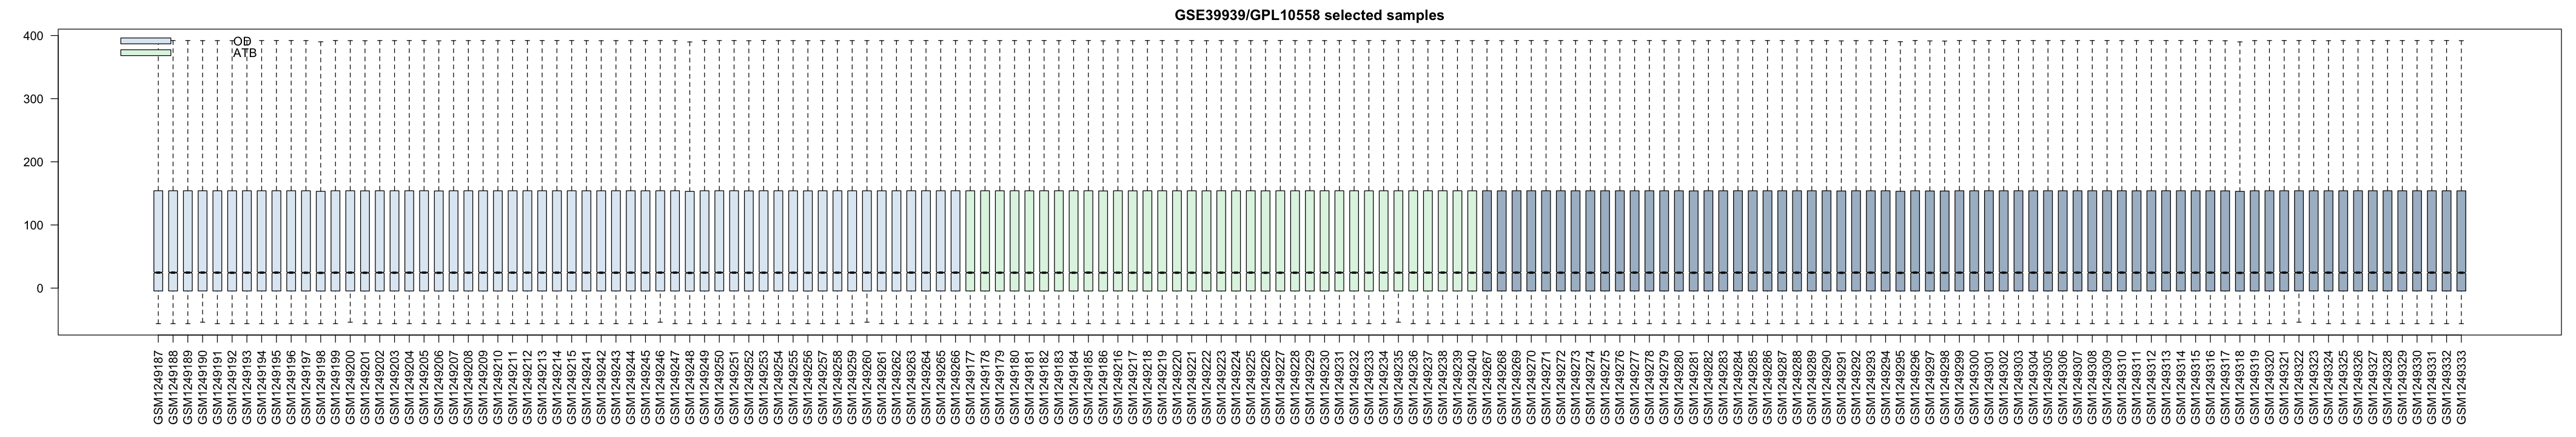

In [15]:
gsms <- paste0("11111111110000000000000000000000000000011111111111",
        "1111111111111100000000000000000000000000XXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXX")
labels <- c("OD","ATB")
draw_boxplot_for_samples("GSE39939", "GPL10558", gsms, labels)

#### Run differential expression analysis between sample groups and export results as CSV file

In [16]:
gsms <- paste0("11111111110000000000000000000000000000011111111111",
        "1111111111111100000000000000000000000000XXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXX")
diff_exp_analysis_for_samples("GSE39939", "GPL10558", gsms, microarray_diff_exp_data)

Found 1 file(s)
GSE39939_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GSE39939_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL10558 found here:
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GPL10558.annot.gz 
Warning message:
“13 parsing failures.
  row     col               expected          actual         file
29686 Gene ID no trailing characters ///283507       literal data
29841 Gene ID no trailing characters ///2074         literal data
30401 Gene ID no trailing characters ///27185///7257 literal data
31184 Gene ID no trailing characters ///57592        literal data
31271 Gene ID no trailing characters ///3199         literal data
..... ....... ...................... ............... ............
See problems(...) for more details.
”Warning message:
“Pa

## Dataset 4

### GSE39940 Cape Town, South Africa (n=157) and Blantyre, Malawi (n=177) (microarray, GPL10558)

- Subjects:334
- Disease status: active tuberculosis (n=111), latent TB infection (n=54), other disease (n=169)
- Disease stage (the second layer): HIV positive (n=107) and negative (n=227)
- Disease status definition: active TB (TB) compared to latent TB infection (LTBI) as well as to other diseases (OD)

Compare ATB (**n=111**) to OD (**n=169**)

#### Check distribution of expression values across samples

Found 1 file(s)
GSE39940_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


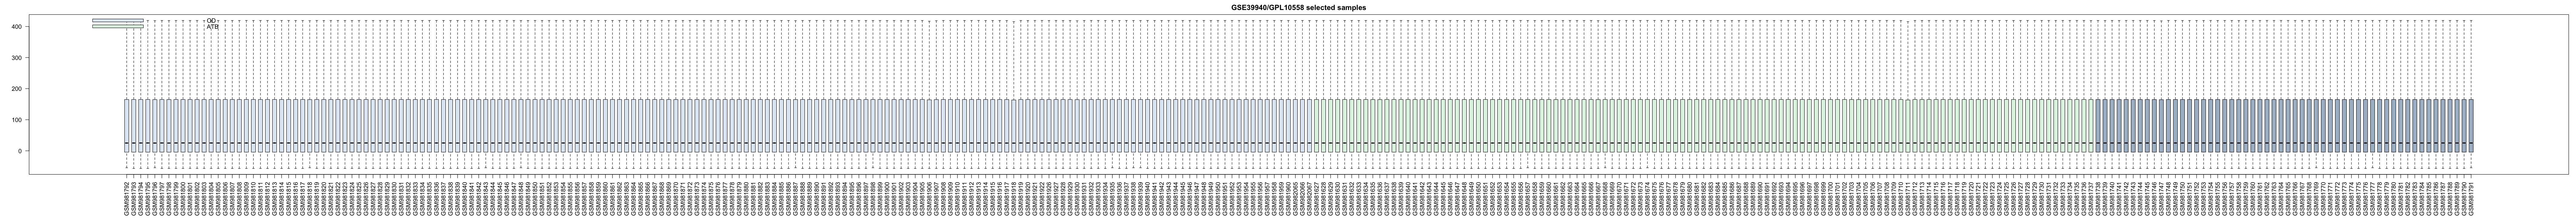

In [17]:
gsms <- paste0("11111111111111111111111111111111111111111111111111",
        "11111111111111111111111111111111111111111111111111",
        "11111111111XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXX00000000000000000000000000000000000",
        "00000000000000000000000000000000000000000000000000",
        "00000000000000000000000000000000000000000000000000",
        "0000000000000000000000000000000000")
labels <- c("OD","ATB")
draw_boxplot_for_samples("GSE39940", "GPL10558", gsms, labels)

#### Run differential expression analysis between sample groups and export results as CSV file

In [18]:
gsms <- paste0("11111111111111111111111111111111111111111111111111",
        "11111111111111111111111111111111111111111111111111",
        "11111111111XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXX00000000000000000000000000000000000",
        "00000000000000000000000000000000000000000000000000",
        "00000000000000000000000000000000000000000000000000",
        "0000000000000000000000000000000000")
diff_exp_analysis_for_samples("GSE39940", "GPL10558", gsms, microarray_diff_exp_data)

Found 1 file(s)
GSE39940_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GSE39940_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL10558 found here:
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GPL10558.annot.gz 
Warning message:
“13 parsing failures.
  row     col               expected          actual         file
29686 Gene ID no trailing characters ///283507       literal data
29841 Gene ID no trailing characters ///2074         literal data
30401 Gene ID no trailing characters ///27185///7257 literal data
31184 Gene ID no trailing characters ///57592        literal data
31271 Gene ID no trailing characters ///3199         literal data
..... ....... ...................... ............... ............
See problems(...) for more details.
”Warning message:
“Pa

## Dataset 5

### GSE42834 : GSE42825: Germany (microarray, GPL10558)

- Subjects:42
- Disease status: TB (n=8), Non-active and Active sarcoidosis (n=11) and Controls (n=23)
- Disease status definition: TB, sarcoidosis, and healthy controls 

Compare ATB (**n=8**) to OD (**n=11**)

#### Check distribution of expression values across samples

Found 1 file(s)
GSE42825_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Warning message in bxp(list(stats = structure(c(-0.10121441, 0.149054285, 0.29154897, :
“some notches went outside hinges ('box'): maybe set notch=FALSE”

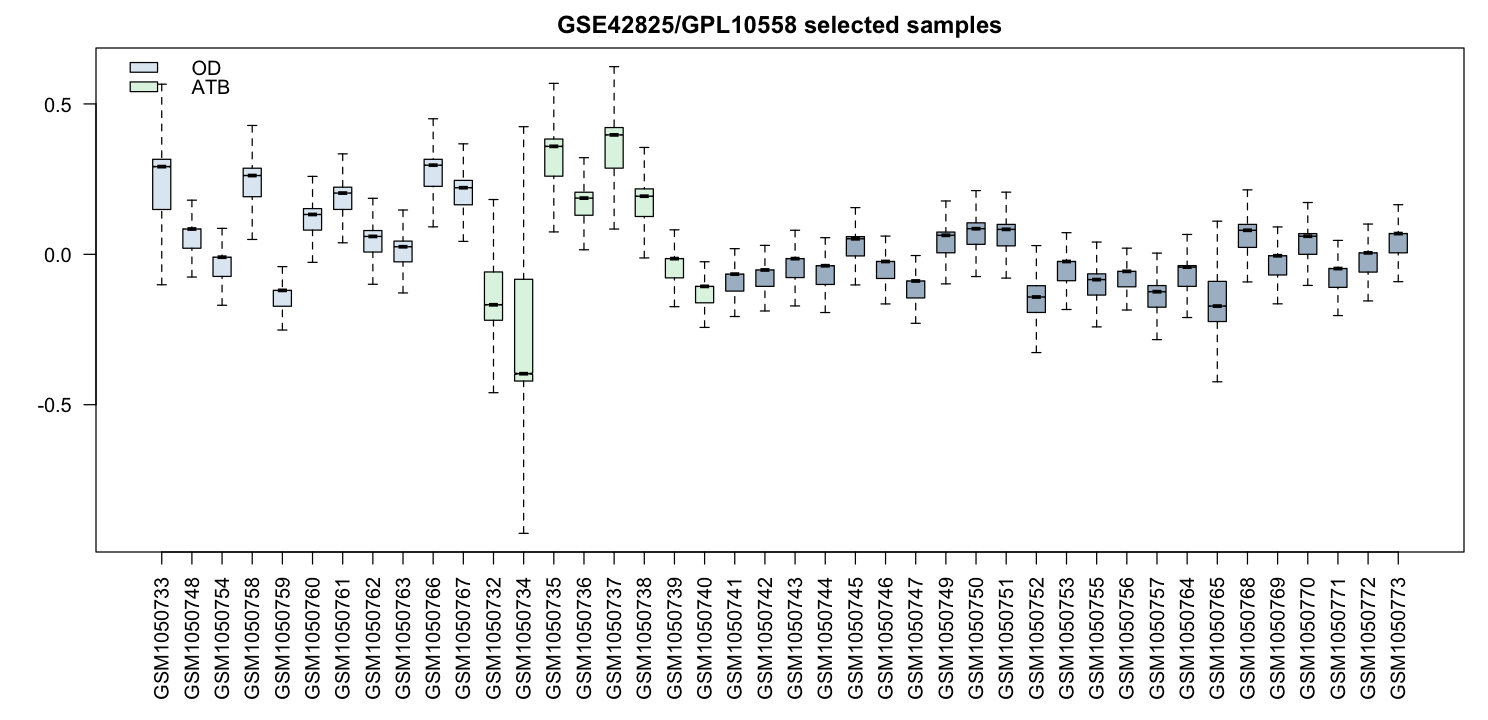

In [19]:
gsms <- "101111111XXXXXXX0XXXXX0XXX000000XX00XXXXXX"
labels <- c("OD","ATB")
draw_boxplot_for_samples("GSE42825", "GPL10558", gsms, labels)

#### Run differential expression analysis between sample groups and export results as CSV file

In [20]:
gsms <- "101111111XXXXXXX0XXXXX0XXX000000XX00XXXXXX"
diff_exp_analysis_for_samples("GSE42825", "GPL10558", gsms, microarray_diff_exp_data)

Found 1 file(s)
GSE42825_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GSE42825_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL10558 found here:
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GPL10558.annot.gz 
Warning message:
“13 parsing failures.
  row     col               expected          actual         file
29686 Gene ID no trailing characters ///283507       literal data
29841 Gene ID no trailing characters ///2074         literal data
30401 Gene ID no trailing characters ///27185///7257 literal data
31184 Gene ID no trailing characters ///57592        literal data
31271 Gene ID no trailing characters ///3199         literal data
..... ....... ...................... ............... ............
See problems(...) for more details.
”

## Dataset 6

### GSE42834 : GSE42826: Germany (microarray, GPL10558)

- Subjects:102
- Disease status: TB (n=11), Non-active and Active sarcoidosis (n=25), Pneumonia (n=6), lung cancer (n=8) and Controls (n=52)
- Disease status definition: TB, sarcoidosis, pneumonia, lung cancer and healthy controls 

Compare ATB (**n=11**) to OD (**n=25+6+8=39**)

#### Check distribution of expression values across samples

Found 1 file(s)
GSE42826_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Warning message in bxp(list(stats = structure(c(-1.7732067, -0.79799795, -0.780555, :
“some notches went outside hinges ('box'): maybe set notch=FALSE”

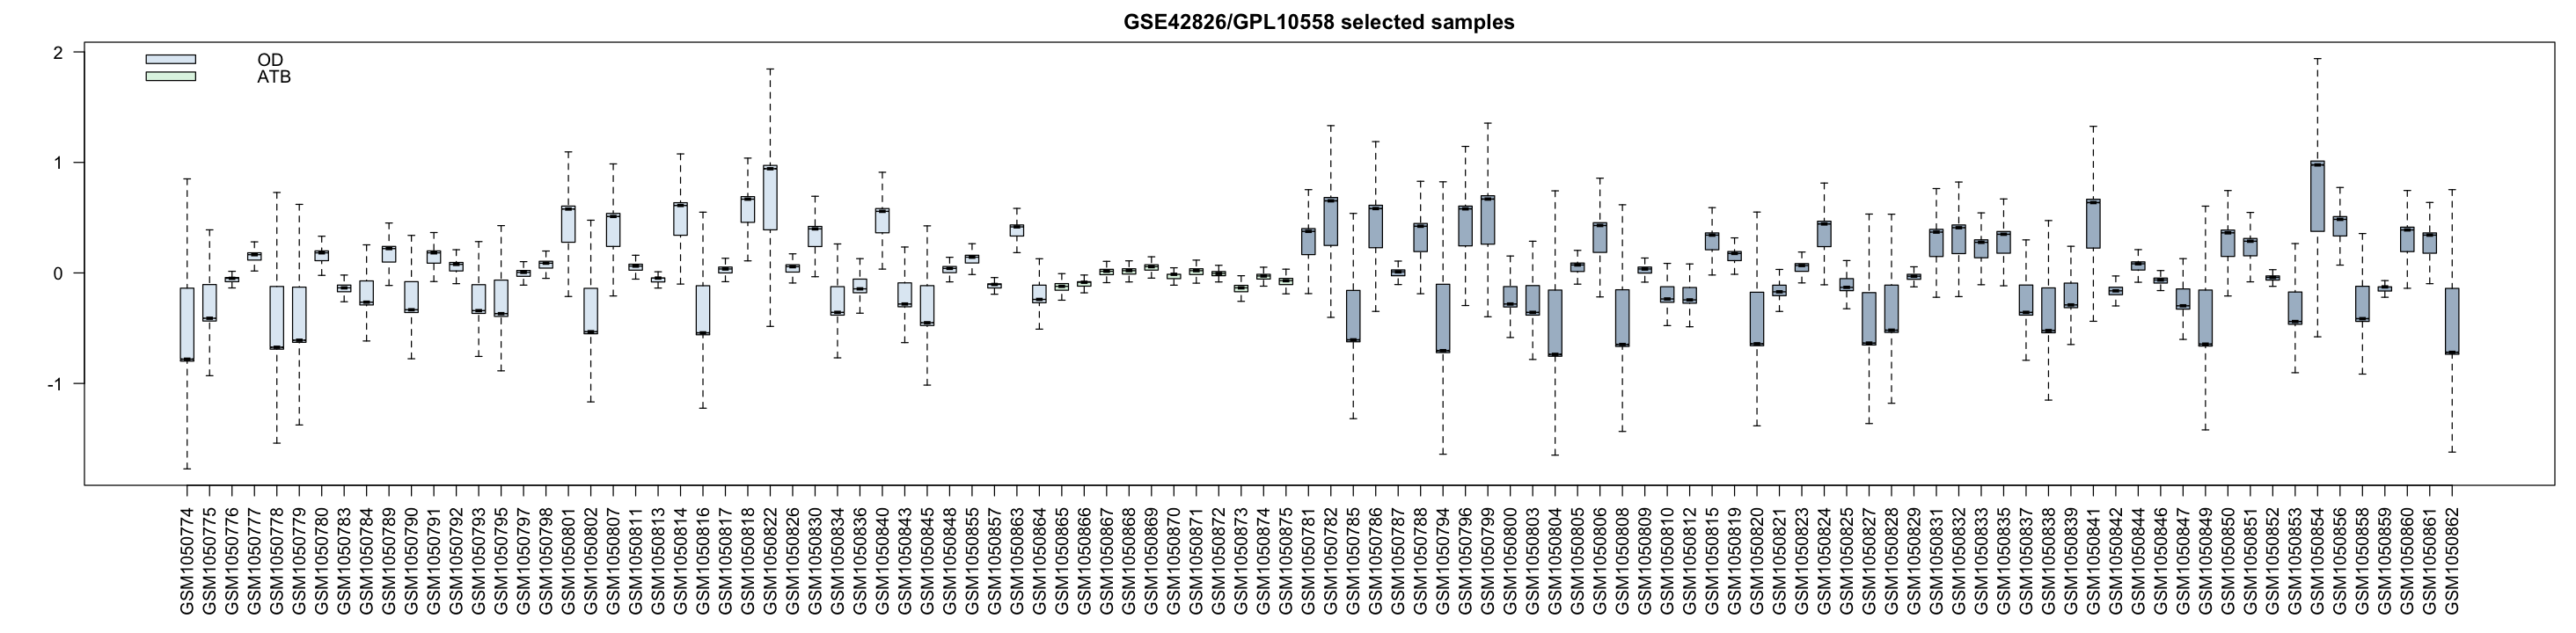

In [21]:
gsms <- paste0("0000000XX00XXXX00000X0X00XX00XXXX0XXX0X00X000XXX0X",
        "XX0XXX0XXX0X0XXX0XX0X0XX0XXXXXX0X0XXXXX00111111111",
        "11")
labels <- c("OD","ATB")
draw_boxplot_for_samples("GSE42826", "GPL10558", gsms, labels)

#### Run differential expression analysis between sample groups and export results as CSV file

In [22]:
gsms <- paste0("0000000XX00XXXX00000X0X00XX00XXXX0XXX0X00X000XXX0X",
        "XX0XXX0XXX0X0XXX0XX0X0XX0XXXXXX0X0XXXXX00111111111",
        "11")
diff_exp_analysis_for_samples("GSE42826", "GPL10558", gsms, microarray_diff_exp_data)

Found 1 file(s)
GSE42826_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GSE42826_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL10558 found here:
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GPL10558.annot.gz 
Warning message:
“13 parsing failures.
  row     col               expected          actual         file
29686 Gene ID no trailing characters ///283507       literal data
29841 Gene ID no trailing characters ///2074         literal data
30401 Gene ID no trailing characters ///27185///7257 literal data
31184 Gene ID no trailing characters ///57592        literal data
31271 Gene ID no trailing characters ///3199         literal data
..... ....... ...................... ............... ............
See problems(...) for more details.
”

## Dataset 7

### GSE42834 : GSE42830: Germany (microarray, GPL10558)

- Subjects:95
- Disease status: TB (n=16), Non-active sarcoidosis and Active Sarcoid (n=25), pneumonia (n=8),lung cancer (n=8) and healthy controls (n=38)
- Disease status definition: TB, sarcoidosis, pneumonia, lung cancer and healthy controls 

Compare ATB (**n=16**) to OD (**n=25+8=33**)

#### Check distribution of expression values across samples

Found 1 file(s)
GSE42830_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


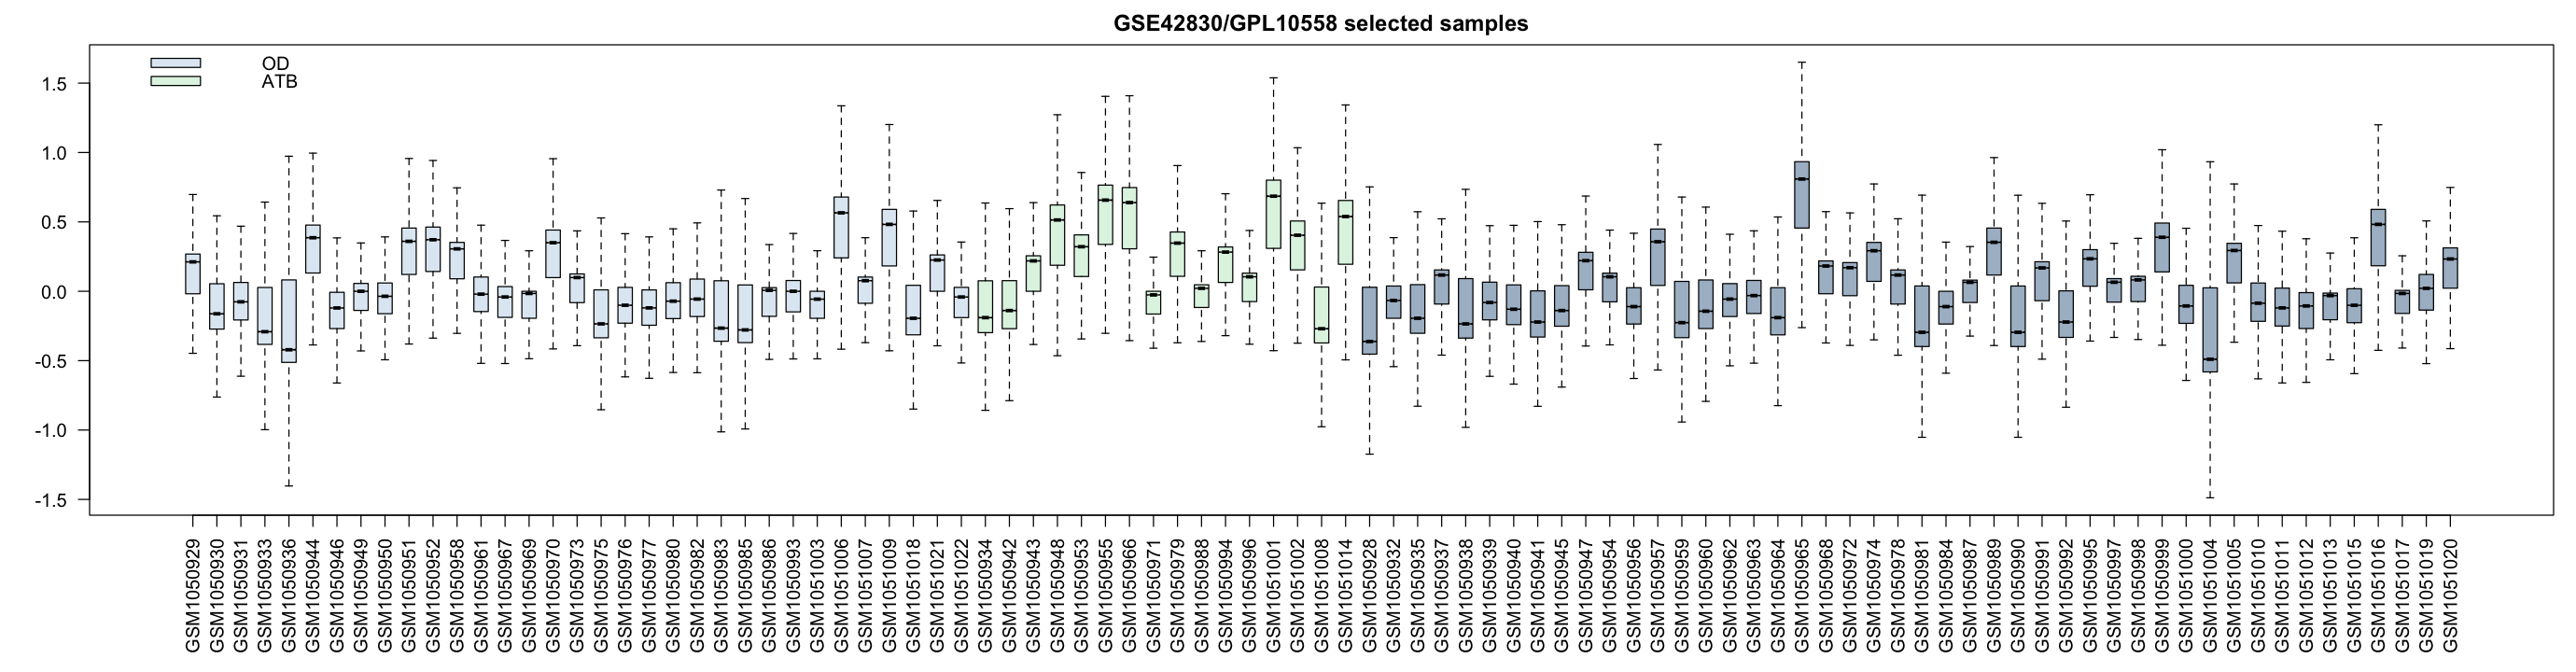

In [23]:
gsms <- paste0("X000X01X0XXXXX110X0X100001X1XX0XX0XXXX10X001X0X000",
        "X10X00X00X1XXXX01X1XXXX110XX0010XXXX1XXX0XX00")
labels <- c("OD","ATB")
draw_boxplot_for_samples("GSE42830", "GPL10558", gsms, labels)

#### Run differential expression analysis between sample groups and export results as CSV file

In [24]:
gsms <- paste0("X000X01X0XXXXX110X0X100001X1XX0XX0XXXX10X001X0X000",
        "X10X00X00X1XXXX01X1XXXX110XX0010XXXX1XXX0XX00")
diff_exp_analysis_for_samples("GSE42830", "GPL10558", gsms, microarray_diff_exp_data)

Found 1 file(s)
GSE42830_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GSE42830_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL10558 found here:
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GPL10558.annot.gz 
Warning message:
“13 parsing failures.
  row     col               expected          actual         file
29686 Gene ID no trailing characters ///283507       literal data
29841 Gene ID no trailing characters ///2074         literal data
30401 Gene ID no trailing characters ///27185///7257 literal data
31184 Gene ID no trailing characters ///57592        literal data
31271 Gene ID no trailing characters ///3199         literal data
..... ....... ...................... ............... ............
See problems(...) for more details.
”

## Dataset 8

### GSE73408 US patients with TB and pneumonia  (microarray, GPL11532)

- Subjects:109
- Disease status: TB (n=35), LTBI (n=35), and PNA (pneumonia) (n=39)
- Disease status definition: TB, LTBI, and PNA (pneumonia)

Compare ATB (**n=35**) to OD (**n=39**)

#### Check distribution of expression values across samples

Found 1 file(s)
GSE73408_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


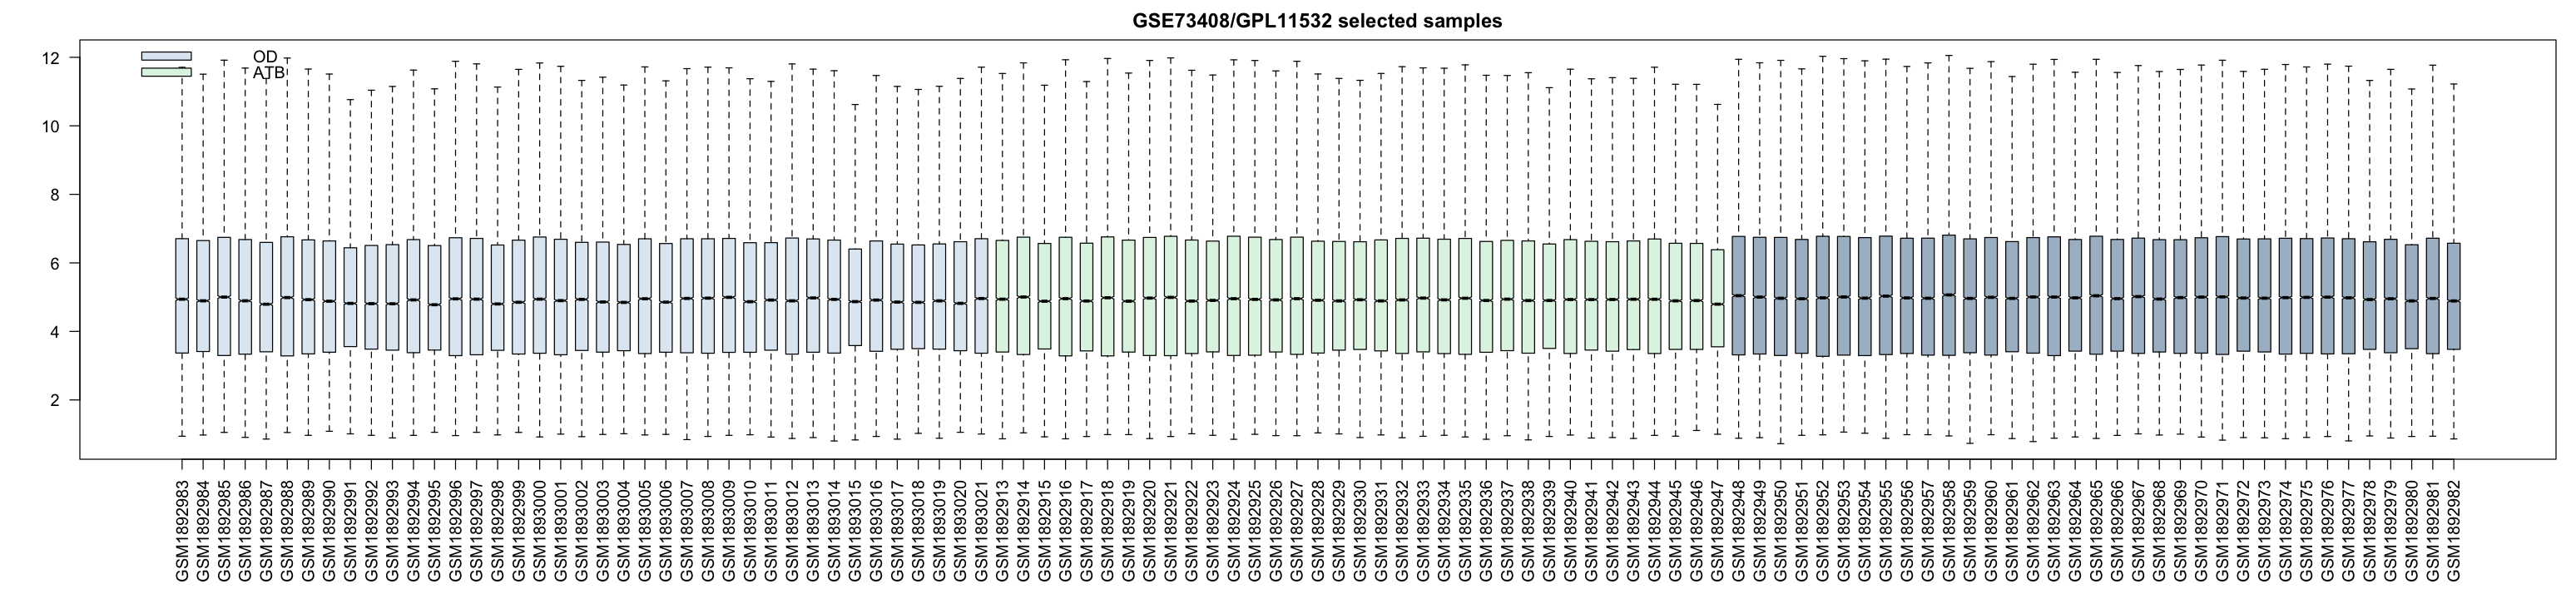

In [25]:
gsms <- paste0("11111111111111111111111111111111111XXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXX000000000000000000000000000000",
        "000000000")
labels <- c("OD","ATB")
draw_boxplot_for_samples("GSE73408", "GPL11532", gsms, labels)

#### Run differential expression analysis between sample groups and export results as CSV file

In [26]:
gsms <- paste0("11111111111111111111111111111111111XXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXX000000000000000000000000000000",
        "000000000")
diff_exp_analysis_for_samples("GSE73408", "GPL11532", gsms, microarray_diff_exp_data)

Found 1 file(s)
GSE73408_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GSE73408_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.
File stored at: 
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GPL11532.annot.gz


## Dataset 9

### GSE62147  Berlin M. tuberculosis and M. africanum patients under TB treatment (microarray, GPL6480)

- Subjects:52
- Disease status: Peripheral blood Maf_post (n=12),Peripheral blood Maf_recruit (n=12), Peripheral blood Mtb_post (n=14) and Peripheral blood Mtb_recruit (n=14)
- Disease status definition: M. tuberculosis and M. africanum patients under TB treatment

Compare ATB (**n=14**) to OD (**n=12**) (analyze recruits)

#### Check distribution of expression values across samples

Found 1 file(s)
GSE62147_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


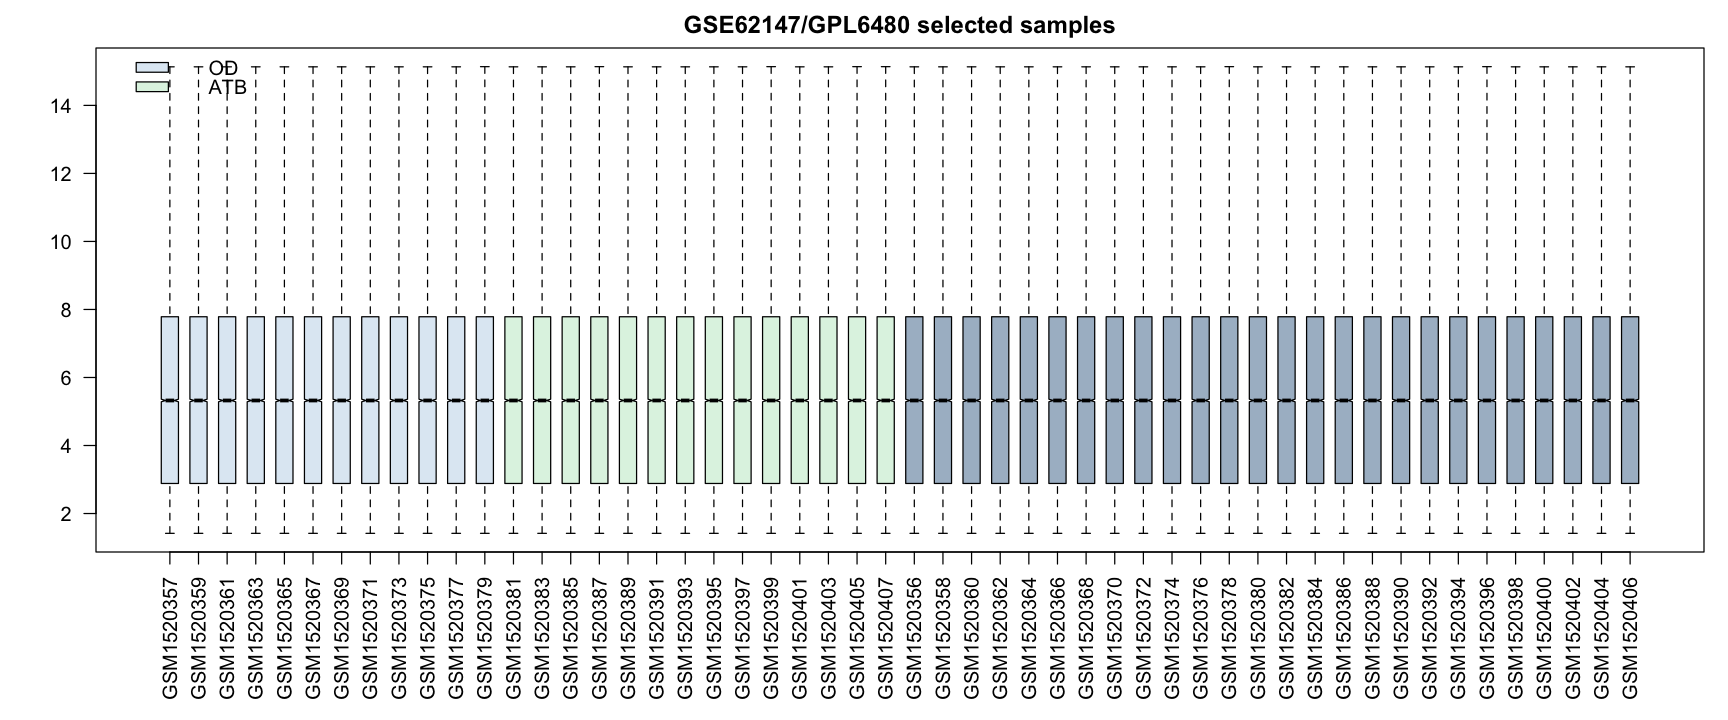

In [27]:
gsms <- "X0X0X0X0X0X0X0X0X0X0X0X0X1X1X1X1X1X1X1X1X1X1X1X1X1X1"
labels <- c("OD","ATB")
draw_boxplot_for_samples("GSE62147", "GPL6480", gsms, labels)

#### Run differential expression analysis between sample groups and export results as CSV file

In [28]:
gsms <- "X0X0X0X0X0X0X0X0X0X0X0X0X1X1X1X1X1X1X1X1X1X1X1X1X1X1"
diff_exp_analysis_for_samples("GSE62147", "GPL6480", gsms, microarray_diff_exp_data)

Found 1 file(s)
GSE62147_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GSE62147_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL6480 found here:
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GPL6480.annot.gz 


## Dataset 10

### GSE83456  UK  (microarray, GPL10558)

- Subjects:202
- Disease status: EPTB (n=47), PTB (n=45), HC (n=61) and Sarcoid (n=49)
- Disease status definition: 61 healthy human controls, 47 human with EPTB (extra-pulmonary TB), 45 human with PTB (pulmonary TB), 49 human with Sarcoid

Compare ATB (**n=45**) to OD (**n=49**)

#### Check distribution of expression values across samples

Found 1 file(s)
GSE83456_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


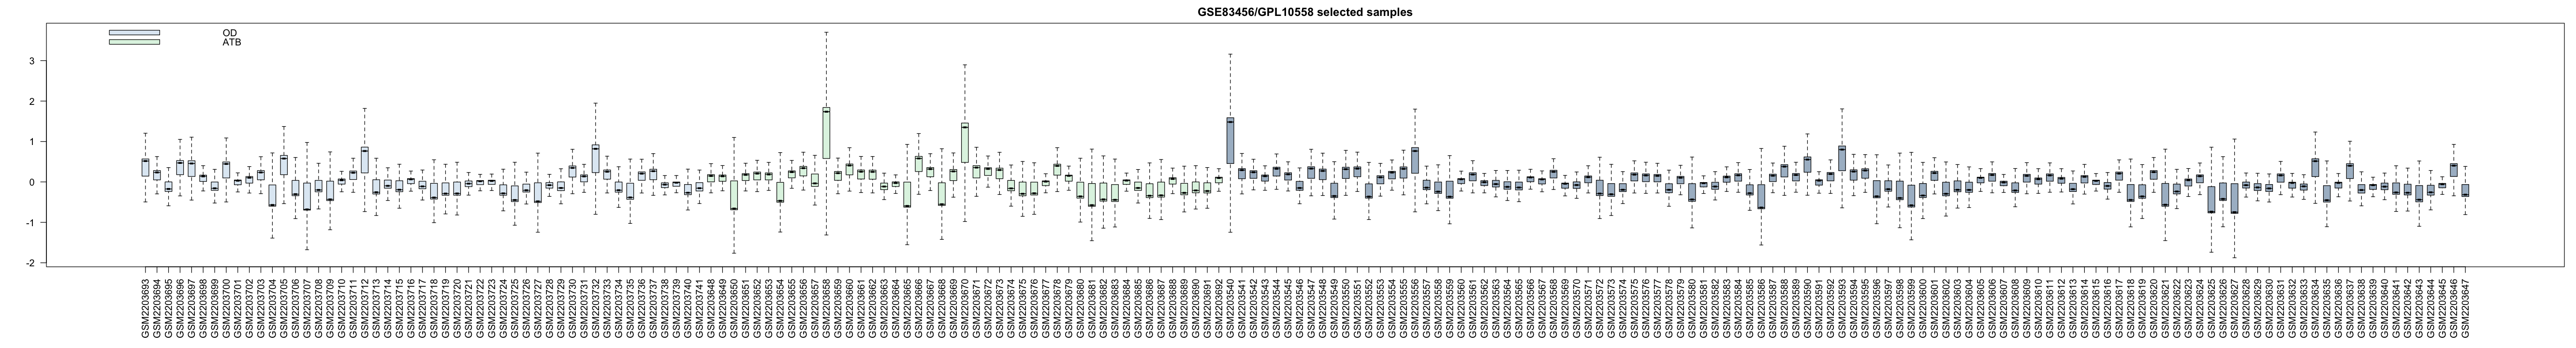

In [29]:
gsms <- paste0("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXX111111111111111111111111111111111111111111",
        "11100000000000000000000000000000000000000000000000",
        "00")
labels <- c("OD","ATB")
draw_boxplot_for_samples("GSE83456", "GPL10558", gsms, labels)

#### Run differential expression analysis between sample groups and export results as CSV file

In [30]:
gsms <- paste0("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXX111111111111111111111111111111111111111111",
        "11100000000000000000000000000000000000000000000000",
        "00")
diff_exp_analysis_for_samples("GSE83456", "GPL10558", gsms, microarray_diff_exp_data)

Found 1 file(s)
GSE83456_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GSE83456_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL10558 found here:
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmpg3sDBb/GPL10558.annot.gz 
Warning message:
“13 parsing failures.
  row     col               expected          actual         file
29686 Gene ID no trailing characters ///283507       literal data
29841 Gene ID no trailing characters ///2074         literal data
30401 Gene ID no trailing characters ///27185///7257 literal data
31184 Gene ID no trailing characters ///57592        literal data
31271 Gene ID no trailing characters ///3199         literal data
..... ....... ...................... ............... ............
See problems(...) for more details.
”